<a href="https://colab.research.google.com/github/PernasA/TP2_SOA/blob/master/HPC/Cuaderno_2_Martes_grupo6a_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 1. Introducción

El Ejercicio 1 del TP3 tiene como objetivo tomar una imagen como entrada, aplicarle el algoritmo escala de imagen, y mostrar la imagen transformada.

El algoritmo "Escala de Imagen" se encarga de reducir el tamaño de la imagen. Su funcionamiento consiste en que cada píxel de salida se reemplaza por su píxel más cercano en la entrada. Se redondean las coordenadas a su entero más cercano. 

Vamos a ejecutar el algoritmo de manera secuencial, haciendo uso de la CPU; y luego haciendo uso de la GPU, con CUDA, realizando una ejecución paralela mediante threads. Una vez ejecutada la función en ambos casos, se mostrará la imagen mediante un plot.

### 2. Armado del ambiente


In [1]:
!pip install validators

### 3. Desarrollo
# CPU


--2021-11-18 22:20:23--  https://www.show.news/__export/1586216624761/sites/debate/img/2020/04/06/pinky_crop1586216591014.jpg_423682103.jpg
Resolving www.show.news (www.show.news)... 13.249.13.2, 13.249.13.42, 13.249.13.97, ...
Connecting to www.show.news (www.show.news)|13.249.13.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110801 (108K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 108.20K  --.-KB/s    in 0.01s   

2021-11-18 22:20:23 (9.61 MB/s) - ‘imagen.jpg’ saved [110801/110801]

Tiempo total de ejecucion:  21622.047 [ms]
Tiempo de procesamiento en CPU:  21495.894 [ms]


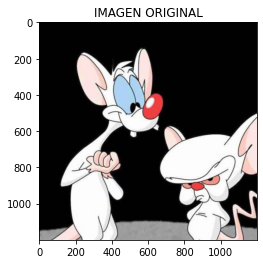

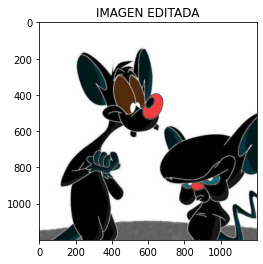

In [2]:
#--------------------------------------BIBLIOTECAS--------------------------------------#
import validators
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import numpy
import sys
try:

  #-----------------------------------PARAMETRO IMAGEN------------------------------------#
  #@title Ingrese la url de una imagen:

  url_imagen = "https://www.show.news/__export/1586216624761/sites/debate/img/2020/04/06/pinky_crop1586216591014.jpg_423682103.jpg" #@param {type: "string" }
  Colores = 'Rojo' #@param ["Blanco", "Negro", "Rojo","Verde","Azul"]

  #Verificacion de que el usuario haya ingresado una URL de imagen valida
  if(url_imagen == "" or not validators.url(url_imagen)):
    raise TypeError("Debe ingresar la url de una imagen.")
  !wget {url_imagen} -O imagen.jpg

  #Defino los rangos de colores
  rango1 = [0,0,0]
  rango2 = [0,0,0] 
  if(Colores == 'Negro'):
    rango1 = [0,0,0]
    rango2 = [50,50,50]
  if(Colores == 'Blanco'):
    rango1 = [200,200,200]
    rango2 = [255,255,255]
  if(Colores == 'Rojo'):
    rango1 = [80,0,0]
    rango2 = [255,170,120]
  if(Colores == 'Azul'):
    rango1 = [0,0,80]
    rango2 = [125,175,255]
  if(Colores == 'Verde'):
    rango1 = [0,80,0]
    rango2 = [175,255,155]

  #Obtencion del tiempo inicial
  tiempo_total = datetime.now()

  #Declaracion de funcion que realiza el pasaje del tiempo obtenido mediante datetime.now(), a milisegundos.
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  #---------------------------------------CODIGO--------------------------------------------#
  # Importación de la imagen y obtencion de sus dimensiones 
  imagen_normal_jpg = Image.open('imagen.jpg')
  width, height = imagen_normal_jpg.size
  
  #Convierto la imagen a array
  imagen_normal = numpy.asarray(imagen_normal_jpg)
  imagen_con_colores_nueva=numpy.empty_like(imagen_normal)

  #Ploteo de la imagen original
  plt.figure()
  plt.title("IMAGEN ORIGINAL")
  imgplot=plt.imshow( imagen_normal )

  #Obtencion del tiempo previo a la ejecucion en GPU
  tiempo_imagen_cpu = datetime.now()

  #Lleno cada pixel de la imagen creada
  for y in range(0,height):
      for x in range(0,width):
        pixel_R, pixel_G, pixel_B = imagen_normal[x][y]
        if(not(pixel_R >=rango1[0] and pixel_G >=rango1[1] 
               and pixel_B  >=rango1[2] 
               and pixel_R <= rango2[0] and 
            pixel_G <= rango2[1] and pixel_B  <= rango2[2])):
          
          imagen_con_colores_nueva[x][y] = [ 255 - pixel_R,  255 - pixel_G , 255 - pixel_B]
       
        else:
          imagen_con_colores_nueva[x][y] = [pixel_R, pixel_G , pixel_B]
  #Calculo del tiempo total de procesamiento de la imagen en GPU
  tiempo_imagen_cpu = datetime.now() - tiempo_imagen_cpu

  #Ploteo de la imagen resultado
  plt.figure()
  plt.title("IMAGEN EDITADA")
  imgplot=plt.imshow( imagen_con_colores_nueva )

  #Calculo del tiempo total de ejecucion del programa
  tiempo_total = datetime.now() - tiempo_total

  print("Tiempo total de ejecucion: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo de procesamiento en CPU: ", tiempo_en_ms( tiempo_imagen_cpu   ), "[ms]" )

except Exception as e:
  print("Error", e )
  sys.exit()

# GPU

In [3]:
!pip install pycuda

--2021-11-18 22:24:20--  https://www.show.news/__export/1586216624761/sites/debate/img/2020/04/06/pinky_crop1586216591014.jpg_423682103.jpg
Resolving www.show.news (www.show.news)... 13.249.13.42, 13.249.13.97, 13.249.13.124, ...
Connecting to www.show.news (www.show.news)|13.249.13.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110801 (108K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 108.20K  --.-KB/s    in 0.01s   

2021-11-18 22:24:20 (10.2 MB/s) - ‘imagen.jpg’ saved [110801/110801]

Imagen del filtro: IMAGEN ORIGINAL - RGB- [1200, 1200]
Thread: [ 19 , 16  ], Bloque : [ 64 , 75 ]
Total de Thread: [ 1216 , 1200  ]  =  1459200
colores:  0 0 0 50 50 50
Tiempo TOTAL:  255.627 [ms]
Tiempo GPU  :  0.502 [ms]


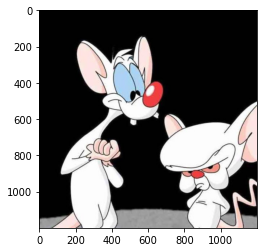

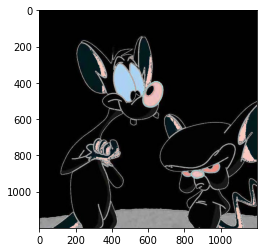

In [10]:
try:
  %matplotlib inline
  from datetime import datetime
  tiempo_total = datetime.now()

  import matplotlib.pyplot as plt
  import sys
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  #@title Ingrese la url de una imagen:

  url_imagen = "https://www.show.news/__export/1586216624761/sites/debate/img/2020/04/06/pinky_crop1586216591014.jpg_423682103.jpg" #@param {type: "string" }
  Colores = 'Negro' #@param ["Blanco", "Negro"]

  #Verificacion de que el usuario haya ingresado una URL de imagen valida
  if(url_imagen == "" or not validators.url(url_imagen)):
    raise TypeError("Debe ingresar la url de una imagen.")
  !wget {url_imagen} -O imagen.jpg

#Defino los rangos de colores
  rango1 = [0,0,0]
  rango2 = [0,0,0] 
  if(Colores == 'Negro'):
    rango1 = [0,0,0]
    rango2 = [50,50,50]
  if(Colores == 'Blanco'):
    rango1 = [200,200,200]
    rango2 = [255,255,255]
  if(Colores == 'Rojo'):
    rango1 = [80,0,0]
    rango2 = [255,170,120]
  if(Colores == 'Azul'):
    rango1 = [0,0,80]
    rango2 = [125,175,255]
  if(Colores == 'Verde'):
    rango1 = [0,80,0]
    rango2 = [175,255,155]


  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  image = Image.open( 'imagen.jpg' ) 

    
  # summarize some details about the image 
  img_alto, img_ancho = image.size 

  # Convierto la imagen comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)
  img_R_cpu = numpy.empty_like( img_O_cpu)

  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

  # #copio los 2 vectores de colores a un array
  # rango1_mem = cuda.mem_alloc(rango1)
  # rango2_mem = cuda.mem_alloc(rango2)

  # #copio los vectores a gpu
  # cuda.memcpy_htod(rango1_mem, rango1)
  # cuda.memcpy_htod(rango2_mem,rango2)

  #Paso los 2 vectores a 6 enteros:
  ini_r = rango1[0]
  ini_g = rango1[1]
  ini_b = rango1[2]

  fin_r = rango2[0]
  fin_g = rango2[1]
  fin_b = rango2[2]
  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( img_O_gpu, img_O_cpu )
  cuda.memcpy_htod( img_R_gpu, img_R_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R,
   int ini_r, int ini_g,int ini_b,
   int fin_r,int fin_g,int fin_b)
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    int limitColor = 255;
    float pixel_R, pixel_G, pixel_B;
 
    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      pixel_R = (float)img_O[(idx+(idy*ancho))*3];
      pixel_G = (float)img_O[(idx+(idy*ancho))*3+1];
      pixel_B = (float)img_O[(idx+(idy*ancho))*3+2];

      if(pixel_R <= 0)pixel_R *=-1;
       if(pixel_G <= 0)pixel_G *=-1;
        if(pixel_B <= 0)pixel_B *=-1;

      if((pixel_R >= ini_r && pixel_G >= ini_g && pixel_B >= ini_b &&
          pixel_R <= fin_r && pixel_G <= fin_g && pixel_B <= fin_b)){

         
    img_R[(idx+(idy*ancho))*3] =  pixel_R;
           img_R[(idx+(idy*ancho))*3+1] = pixel_G;
           img_R[(idx+(idy*ancho))*3+2] =  pixel_B;
      }else{
          img_R[(idx+(idy*ancho))*3] = limitColor - pixel_R;
         img_R[(idx+(idy*ancho))*3+1] = limitColor - pixel_G;
         img_R[(idx+(idy*ancho))*3+2] = limitColor - pixel_B;
      }
    }
      
  }
  """) 


  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: IMAGEN ORIGINAL - " + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")

  tiempo_GPU_img = datetime.now()

  dim_hilo_x = 19
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 16
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_GPU_img = datetime.now()

  print("colores: ",ini_r,ini_g,ini_b,fin_r,fin_g,fin_b)

  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), 
         img_O_gpu, img_R_gpu,

         numpy.int32(ini_r) , numpy.int32(ini_g) ,numpy.int32(ini_b),
         numpy.int32(fin_r) , numpy.int32(fin_g) ,numpy.int32(fin_b),

         block=( dim_hilo_x, dim_hilo_y, 1 ), 
         grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_GPU_img = datetime.now() - tiempo_GPU_img

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  tiempo_total = datetime.now() - tiempo_total

  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_GPU_img ), "[ms]" )
except Exception as e:
  print("Error: ", e)
  sys.exit()


# 4. Conclusiones

Observando las metricas, podemos concluir que el procesamiento de la imagen en GPU se realiza más rapido que en CPU, en promedio 2.840 veces más rapido. Esto se debe a que en GPU se realizan operaciones de manera paralela mientras que en CPU se realizan las operaciones de manera secuencial. En cuanto a la eficacia del algortimo, en CPU es mayor que en GPU debido a la disminucion de la precision de los valores de los pixeles. Se podria mejorar la eficacia del filtro en GPU utilizando distintas dimensiones y valores en la matriz kernel. También, es más dificil de implementar el algoritmo en GPU.

# 5. Bibliografía

[1] Algoritmo de escala - Towards data science: https://towardsdatascience.com/image-processing-image-scaling-algorithms-ae29aaa6b36c

[2] Algoritmo de escala: -OpenCV: https://docs.opencv.org/4.4.0/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d


[3] Cuda - Documentación Oficial Nvidia:  https://docs.nvidia.com/cuda/

[4] Python basico UNLaM: https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb
